### In this notebook I use linear regression to predict 2017 NBA player salaries using their 2016 performance statistics. I make several models: using all features, subsetting on those with significant p-values, subsetting on all but the team variable, Lasso ($L^1$) regularization, and using only features that a player can improve himself.

### I actually tried about twice as many variations, including Ridge, Ridge CV, including polynomial features, and other subsets of features, but chose to present only the more successful models.

In [75]:
import pickle
import pandas as pd
import numpy as np
import requests
import re
from bs4 import BeautifulSoup
import scipy
import patsy
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
%matplotlib inline

# Import pickled data from get_2016_data.ipynb

In [51]:
with open("2016_2017.pkl", 'rb') as picklefile: 
    df = pickle.load(picklefile)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,Trey Burke,3386598,3,73,191,Right,23,UTA,NBA,PG,...,.817,0.3,1.5,1.8,2.3,0.5,0.1,1.3,1.3,10.6
1,Nemanja Bjelica,3800000,1,82,240,Right,27,MIN,NBA,PF,...,.727,0.8,2.7,3.5,1.4,0.4,0.4,0.8,2.6,5.1
2,Nerlens Noel,4384490,2,83,228,Right,21,PHI,NBA,C,...,.590,2.3,5.8,8.1,1.8,1.8,1.5,2.4,2.9,11.1
3,Frank Kaminsky,2730000,1,84,242,Right,22,CHO,NBA,C,...,.730,0.9,3.3,4.1,1.2,0.5,0.5,0.7,1.6,7.5
4,Gorgui Dieng,2348783,3,83,241,Right,26,MIN,NBA,C,...,.827,1.9,5.2,7.1,1.7,1.1,1.2,1.7,2.7,10.1


# Cleaning data

### Add Column Names

In [52]:
# we get the majority of the column names from the website using scraping, because they all lie in one table.
url="http://www.basketball-reference.com/players/b/babbilu01.html"

response=requests.get(url)
page=response.text
page = re.sub('<!--', '', page)
page = re.sub('-->', '', page)

soup=BeautifulSoup(page, 'lxml')
cols=[elt.get_text() for elt in soup.find(id='per_game').find('thead').find_all('th')]
cols=cols[1:]

cols=['Name','Salary','Experience','Height','Weight','Shoots']+cols
df.columns=cols

df.columns

Index(['Name', 'Salary', 'Experience', 'Height', 'Weight', 'Shoots', 'Age',
       'Tm', 'Lg', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA',
       '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

#### Some of the libraries we're going to use don't like the '%' symbol, or numerals being the leading character of a feature name. We'll replace the '%' with a P and move the numerals to the end of the feature name.

In [53]:
df.columns=['Name', 'Salary', 'Experience', 'Height', 'Weight', 'Shoots', 'Age',
       'Tm', 'Lg', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA', 'FGP', 'P3', 'PA3',
       'PP3', 'P2', 'PA2', 'PP2', 'eFGP', 'FT', 'FTA', 'FTP', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']

#### There are some missing values. Here we see that they occur in the 15, 18, 21, 22, 25 columns, which are field goal percentage, 3 point percentage, 2 point percentage, effective field goal percentage, and free throw percentage. There are not that many total missing values, so we'll replace them with 0s.

In [54]:
np.where(df.applymap(lambda x: x == ''))

(array([  5,  19,  19,  27,  30,  33,  33,  53,  63,  79,  84,  92, 106,
        114, 117, 122, 123, 137, 182, 186, 197, 200, 225, 225, 225, 225,
        225, 237, 253, 254, 271, 273, 281, 304, 309, 344]),
 array([25, 21, 25, 18, 18, 18, 25, 18, 18, 18, 18, 18, 18, 18, 18, 25, 25,
        18, 18, 18, 18, 18, 15, 18, 21, 22, 25, 18, 18, 18, 18, 18, 18, 18,
        18, 18]))

In [55]:
df=df.replace('', 0)

#### Since every player is in the NBA league, we'll drop that feature.

In [56]:
df.Lg.unique()

array(['NBA'], dtype=object)

In [57]:
df=df.drop('Lg',axis=1)

#### Let's restrict to players with 3 years of experience because the salary for rookies is determined by the number in which they were picked in the draft.

In [58]:
df.Experience.unique()

array(['3', '1', '2', '5', '8', '13', '4', '11', '7', '16', '9', '10',
       '15', '12', '6', '17', '14', '18', 'Blue'], dtype=object)

In [59]:
df[df.Experience=='Blue']

,Name,Salary,Experience,Height,Weight,Shoots,Age,Tm,Pos,G,...,FTP,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
360,James Michael McAdoo,980431,Blue,81,230,Right,23,GSW,PF,41,...,.531,0.7,0.7,1.4,0.4,0.2,0.2,0.4,1.0,2.9


#### I looked up James McAdoo, and it turns out he was a rookie. So we can just drop him anyway.

In [60]:
df=df[df.Experience!='Blue']
df['Experience']=df.Experience.apply(int)
df=df[df.Experience>2]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273 entries, 0 to 370
Data columns (total 34 columns):
Name          273 non-null object
Salary        273 non-null object
Experience    273 non-null int64
Height        273 non-null object
Weight        273 non-null object
Shoots        273 non-null object
Age           273 non-null object
Tm            273 non-null object
Pos           273 non-null object
G             273 non-null object
GS            273 non-null object
MP            273 non-null object
FG            273 non-null object
FGA           273 non-null object
FGP           273 non-null object
P3            273 non-null object
PA3           273 non-null object
PP3           273 non-null object
P2            273 non-null object
PA2           273 non-null object
PP2           273 non-null object
eFGP          273 non-null object
FT            273 non-null object
FTA           273 non-null object
FTP           273 non-null object
ORB           273 non-null object
DRB         

#### Notice that ~100 of the ~ 400 players were rookies.

In [61]:
cols=df.columns.values
for col in cols:
    if col not in ['Name', 'Shoots', 'Pos','Tm']:
        df[col]=df[col].apply(float)

#### Multi collinearity: notice that FGA=PA2+PA3. That is, field goal attempts is the sum of 2 point attempts and 3 point attempts. For ease of interpretability, let's keep PA2 and PA3, and remove FGA.

In [63]:
df=df.drop('FGA',axis=1)

## Normalize data and make dummies

In [66]:
#make dummy variables
df_dummy = patsy.dmatrix('Tm + Pos + Shoots', data=df, return_type="dataframe")
df_dummy[['Salary', 'Experience', 'Height', 'Weight', 'Age',
       'G', 'GS', 'MP', 'FG', 'FGP', 'P3', 'PA3', 'PP3',
       'P2', 'PA2', 'PP2', 'eFGP', 'FT', 'FTA', 'FTP', 'ORB', 'DRB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']] \
        =df[['Salary', 'Experience', 'Height', 'Weight', 'Age',
       'G', 'GS', 'MP', 'FG', 'FGP', 'P3', 'PA3', 'PP3',
       'P2', 'PA2', 'PP2', 'eFGP', 'FT', 'FTA', 'FTP', 'ORB', 'DRB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']]
df_dummy.head()

,Intercept,Tm[T.BOS],Tm[T.BRK],Tm[T.CHI],Tm[T.CHO],Tm[T.CLE],Tm[T.DAL],Tm[T.DEN],Tm[T.DET],Tm[T.GSW],...,FTP,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.817,0.3,1.5,1.8,2.3,0.5,0.1,1.3,1.3,10.6
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.827,1.9,5.2,7.1,1.7,1.1,1.2,1.7,2.7,10.1
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.874,1.3,5.5,6.8,2.6,1.8,1.0,1.5,1.8,21.2
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.805,0.1,1.4,1.5,3.2,0.6,0.1,1.4,1.4,7.5
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.750,0.3,1.8,2.0,0.4,0.1,0.1,0.1,0.7,1.6


In [68]:
X_norm=df_dummy.drop('Salary', axis=1)
Y_norm=df['Salary']
Y_norm=Y_norm.reset_index(drop=True)

#normalize
X_norm=preprocessing.normalize(X_norm, axis=0)
df_dummy.columns
X_norm=pd.DataFrame(X_norm, columns=[feat for feat in list(df_dummy.columns) if feat!='Salary'])

In [69]:
df_dummy=pd.concat([Y_norm,X_norm],axis=1)
df_dummy.head()

,Salary,Intercept,Tm[T.BOS],Tm[T.BRK],Tm[T.CHI],Tm[T.CHO],Tm[T.CLE],Tm[T.DAL],Tm[T.DEN],Tm[T.DET],...,FTP,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,3386598.0,0.060523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.064732,0.013563,0.023816,0.021558,0.046296,0.033692,0.008681,0.049300,0.038207,0.053626
1,2348783.0,0.060523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.065524,0.085901,0.082561,0.085033,0.034219,0.074122,0.104171,0.064469,0.079353,0.051097
2,17638063.0,0.060523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.069248,0.058774,0.087324,0.081440,0.052334,0.121290,0.086809,0.056885,0.052902,0.107253
3,7250000.0,0.060523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.063781,0.004521,0.022228,0.017965,0.064411,0.040430,0.008681,0.053092,0.041146,0.037943
4,4000000.0,0.060523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.059424,0.013563,0.028579,0.023953,0.008051,0.006738,0.008681,0.003792,0.020573,0.008095


In [70]:
df_dummy.columns

Index(['Salary', 'Intercept', 'Tm[T.BOS]', 'Tm[T.BRK]', 'Tm[T.CHI]',
       'Tm[T.CHO]', 'Tm[T.CLE]', 'Tm[T.DAL]', 'Tm[T.DEN]', 'Tm[T.DET]',
       'Tm[T.GSW]', 'Tm[T.HOU]', 'Tm[T.IND]', 'Tm[T.LAC]', 'Tm[T.LAL]',
       'Tm[T.MEM]', 'Tm[T.MIA]', 'Tm[T.MIL]', 'Tm[T.MIN]', 'Tm[T.NOP]',
       'Tm[T.NYK]', 'Tm[T.OKC]', 'Tm[T.ORL]', 'Tm[T.PHI]', 'Tm[T.PHO]',
       'Tm[T.POR]', 'Tm[T.SAC]', 'Tm[T.SAS]', 'Tm[T.TOR]', 'Tm[T.TOT]',
       'Tm[T.UTA]', 'Tm[T.WAS]', 'Pos[T.PF]', 'Pos[T.PF-C]', 'Pos[T.PG]',
       'Pos[T.SF]', 'Pos[T.SG]', 'Shoots[T.Right]', 'Shoots[T.played,...]',
       'Experience', 'Height', 'Weight', 'Age', 'G', 'GS', 'MP', 'FG', 'FGP',
       'P3', 'PA3', 'PP3', 'P2', 'PA2', 'PP2', 'eFGP', 'FT', 'FTA', 'FTP',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

# Modelling

## Model  1 - benchmark, all features
### Cross-validated $R^2 \approx 0.35$

In [289]:
model1 = sm.OLS(Y_norm, X_norm)
fit1 = model1.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     7.521
Date:                Tue, 31 Jan 2017   Prob (F-statistic):           6.64e-29
Time:                        12:18:00   Log-Likelihood:                -4473.4
No. Observations:                 270   AIC:                             9077.
Df Residuals:                     205   BIC:                             9311.
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept       -1.135e+08   3.21e+08     -0.354      0.724     -7.45e+08  5.19e+08
Tm[T.BOS]       -6.481e+06   6.31e+06     -1.027      0.306     -1.89e+07  5.96e+06
Tm[T.BRK]        6.285e+04   5.55e+06      0.011      0.991     -1.09e+07   1.1e+07
Tm[T.CHI]       -2.049e+06   6.77e+06     -0.303      0.762     -1.54e+07  1.13e+07
Tm[T.CHO]       -6.098e+06   6.67e+06     -0.914      0.362     -1.93e+07  7.06e+06
Tm[T.CLE]        9.899e+06   6.68e+06      1.482      0.140     -3.27e+06  2.31e+07
Tm[T.DAL]       -2.771e+06   6.56e+06     -0.422      0.673     -1.57e+07  1.02e+07
Tm[T.DEN]       -1.185e+07   6.38e+06     -1.856      0.065     -2.44e+07  7.35e+05
Tm[T.DET]       -5.227e+06   6.36e+06     -0.821      0.412     -1.78e+07  7.32e+06
Tm[T.GSW]       -1.087e+06   6.87e+06     -0.158      0.874     -1.46e+07  1.25e+07
Tm[T.HOU]       -5.155e+06   6.58e+06     -0.783      0.434     -1.81e+07  7.82e+06
Tm[T.IND]        1.887e+05   6.35e+06      0.030      0.976     -1.23e+07  1.27e+07
Tm[T.LAC]       -7.925e+05   6.61e+06     -0.120      0.905     -1.38e+07  1.22e+07
Tm[T.LAL]       -1.105e+07   6.31e+06     -1.752      0.081     -2.35e+07  1.39e+06
Tm[T.MEM]        1.478e+06   6.29e+06      0.235      0.814     -1.09e+07  1.39e+07
Tm[T.MIA]        4.626e+06   6.23e+06      0.742      0.459     -7.67e+06  1.69e+07
Tm[T.MIL]       -3.475e+06   6.23e+06     -0.558      0.577     -1.58e+07   8.8e+06
Tm[T.MIN]       -8.712e+06   5.31e+06     -1.639      0.103     -1.92e+07  1.76e+06
Tm[T.NOP]       -4.202e+06   6.81e+06     -0.617      0.538     -1.76e+07  9.22e+06
Tm[T.NYK]       -1.875e+06   6.47e+06     -0.290      0.772     -1.46e+07  1.09e+07
Tm[T.OKC]        9.327e+05   6.59e+06      0.141      0.888     -1.21e+07  1.39e+07
Tm[T.ORL]       -3.586e+06   6.05e+06     -0.593      0.554     -1.55e+07  8.34e+06
Tm[T.PHI]       -1.505e+07   5.61e+06     -2.684      0.008     -2.61e+07    -4e+06
Tm[T.PHO]        -2.54e+06   6.46e+06     -0.393      0.695     -1.53e+07  1.02e+07
Tm[T.POR]       -2.966e+05   6.56e+06     -0.045      0.964     -1.32e+07  1.26e+07
Tm[T.SAC]       -7.515e+06    6.6e+06     -1.138      0.256     -2.05e+07   5.5e+06
Tm[T.SAS]        1.977e+06   6.17e+06      0.320      0.749     -1.02e+07  1.41e+07
Tm[T.TOR]         4.08e+06   6.83e+06      0.597      0.551     -9.39e+06  1.76e+07
Tm[T.TOT]       -1.011e+07   8.66e+06     -1.167      0.245     -2.72e+07  6.97e+06
Tm[T.UTA]       -7.291e+06   6.21e+06     -1.174      0.242     -1.95e+07  4.95e+06
Tm[T.WAS]       -4.848e+06   6.48e+06     -0.748      0.455     -1.76e+07  7.93e+06
Pos[T.PF]       -1.026e+07   8.66e+06     -1.186      0.237     -2.73e+07  6.81e+06
Pos[T.PF-C]      4.229e+06   4.89e+06      0.864      0.388     -5.42e+06  1.39e+07
Pos[T.PG]       -4.591e+07   1.77e+07     -2.588      0.010

In [89]:
def cross_val_R2_RMSE(X,Y,model):
    kf = KFold(n=len(X), n_folds=5, shuffle=True)

    rmse_list=[]
    r_sq_list=[]
    for train, test in kf:
        X_train=X.iloc[train]
        Y_train=Y.iloc[train]
        X_test=X.iloc[test]
        Y_test=Y.iloc[test]
    
        model=sm.OLS(Y_train, X_train)
        fit=model.fit()
        SS_res=sum((Y_test-fit.predict(X_test))**2)
        SS_tot=(len(Y_test))*(Y_test.var())
        r_sq_list.append(1-(SS_res/SS_tot))
        rmse=(np.mean((Y_test-fit.predict(X_test))**2))**(1/2)
        rmse_list.append(rmse)
    
    print(r_sq_list)
    print('mean R^2',sum(r_sq_list)/5)
    print(rmse_list)
    print('mean rmse', sum(rmse_list)/5)

In [290]:
cross_val_R2_RMSE(X_norm, Y_norm, model1)

[0.14748727680236828, 0.32887394016002991, 0.55004637019313551, 0.51918686487621013, 0.22561821192271925]
mean R^2 0.354242532791
[5763873.950022517, 5869003.129077225, 4911743.904535298, 4964603.147302966, 5384332.082820584]
mean rmse 5378711.242751718


### Plot the residuals to check for heteroskedasticity

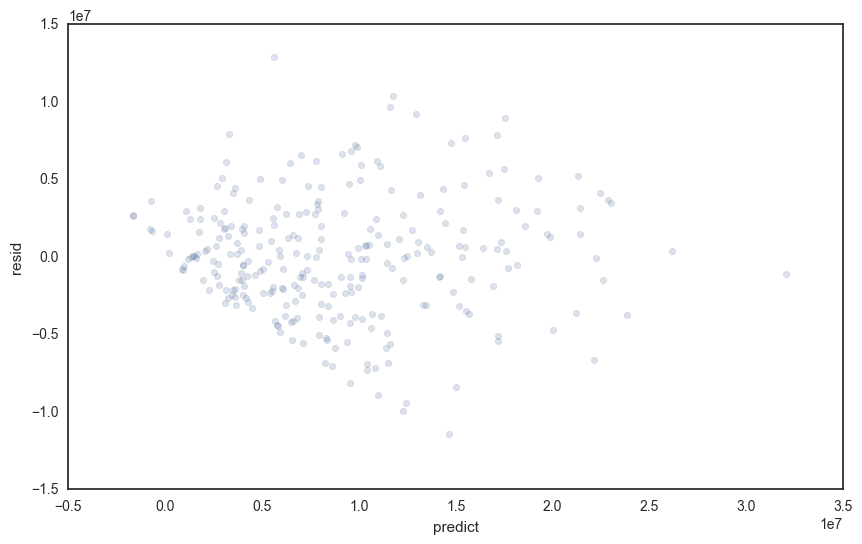

In [291]:
import seaborn as sns
%matplotlib inline
df_dummy['predict']=fit1.predict(X_norm)
df_dummy['resid']=df_dummy['Salary']-df_dummy['predict']
with sns.axes_style('white'):
    plot=df_dummy.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))

### QQ plot to check for linearity

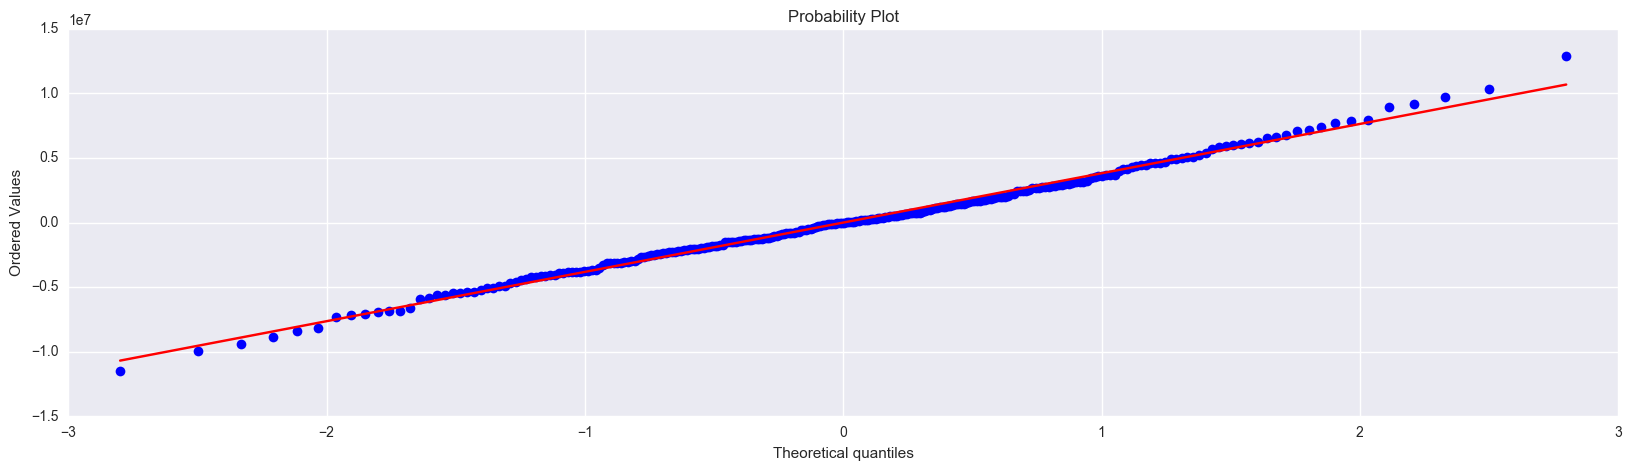

In [292]:
import scipy.stats as stats
plt.figure(figsize=(20,5))
stats.probplot(df_dummy['resid'], dist="norm", plot=plt)
plt.show()


#### Let's drop 'resid' and 'predict' since we don't want to use them for predictions

In [293]:
df_dummy=df_dummy.drop(['resid','predict'],axis=1)

## Model 2: Only the significant p-values
#### Keep the entire category if one categorical significant
### Cross validated $R^2\approx 0.5$

In [294]:
fit1.pvalues.sort_values()

AST                0.000054
Tm[T.PHI]          0.007863
TOV                0.009825
Pos[T.PG]          0.010337
STL                0.023016
MP                 0.024541
PP2                0.046080
PA3                0.062949
Tm[T.DEN]          0.064821
Tm[T.LAL]          0.081323
FG                 0.095608
Tm[T.MIN]          0.102644
Pos[T.SG]          0.114158
Tm[T.CLE]          0.139904
Weight             0.145533
Pos[T.SF]          0.182592
PA2                0.216632
Pos[T.PF]          0.237192
Tm[T.UTA]          0.241668
Height             0.243520
Tm[T.TOT]          0.244621
PF                 0.248227
FGP                0.249579
Tm[T.SAC]          0.256407
FTP                0.277787
Tm[T.BOS]          0.305566
FT                 0.320707
PTS                0.327139
P3                 0.333307
Tm[T.CHO]          0.361981
                     ...   
FTA                0.454337
Tm[T.WAS]          0.455392
Tm[T.MIA]          0.458971
GS                 0.484527
ORB                0

In [297]:
# get the features with significant p-values
feats=list(fit1.pvalues[fit1.pvalues<.1].index)
feats=[feat for feat in feats if '[' not in feat]
feats=['Salary']+ feats +[feat for feat in list(df_dummy.columns) if '[' in feat]
feats.remove('Shoots[T.Right]')
feats

['Salary',
 'MP',
 'FG',
 'PA3',
 'PP2',
 'AST',
 'STL',
 'TOV',
 'Tm[T.BOS]',
 'Tm[T.BRK]',
 'Tm[T.CHI]',
 'Tm[T.CHO]',
 'Tm[T.CLE]',
 'Tm[T.DAL]',
 'Tm[T.DEN]',
 'Tm[T.DET]',
 'Tm[T.GSW]',
 'Tm[T.HOU]',
 'Tm[T.IND]',
 'Tm[T.LAC]',
 'Tm[T.LAL]',
 'Tm[T.MEM]',
 'Tm[T.MIA]',
 'Tm[T.MIL]',
 'Tm[T.MIN]',
 'Tm[T.NOP]',
 'Tm[T.NYK]',
 'Tm[T.OKC]',
 'Tm[T.ORL]',
 'Tm[T.PHI]',
 'Tm[T.PHO]',
 'Tm[T.POR]',
 'Tm[T.SAC]',
 'Tm[T.SAS]',
 'Tm[T.TOR]',
 'Tm[T.TOT]',
 'Tm[T.UTA]',
 'Tm[T.WAS]',
 'Pos[T.PF]',
 'Pos[T.PF-C]',
 'Pos[T.PG]',
 'Pos[T.SF]',
 'Pos[T.SG]']

In [298]:
df_feats=df_dummy[feats]
df_feats

,Salary,MP,FG,PA3,PP2,AST,STL,TOV,Tm[T.BOS],Tm[T.BRK],...,Tm[T.SAS],Tm[T.TOR],Tm[T.TOT],Tm[T.UTA],Tm[T.WAS],Pos[T.PF],Pos[T.PF-C],Pos[T.PG],Pos[T.SF],Pos[T.SG]
0,26540100.0,0.085944,0.108938,0.034070,0.056681,0.080542,0.067448,0.083499,0.000000,0.0,...,0.0,0.301511,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.129099
1,5000000.0,0.043331,0.031716,0.060569,0.050617,0.070474,0.040469,0.045545,0.000000,0.0,...,0.0,0.000000,0.204124,0.000000,0.000000,0.000000,0.0,0.140028,0.000000,0.000000
2,15000000.0,0.067510,0.060674,0.051105,0.058166,0.034230,0.047213,0.045545,0.000000,0.0,...,0.0,0.000000,0.204124,0.000000,0.000000,0.000000,0.0,0.000000,0.138675,0.000000
3,1800000.0,0.026334,0.024821,0.000000,0.051236,0.020135,0.013490,0.034159,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
4,8800000.0,0.068228,0.075843,0.066248,0.056186,0.118799,0.080937,0.106272,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.140028,0.000000,0.000000
5,1551659.0,0.010533,0.011032,0.028392,0.041211,0.000000,0.000000,0.003795,0.000000,0.0,...,0.0,0.000000,0.204124,0.000000,0.000000,0.133631,0.0,0.000000,0.000000,0.000000
6,13253012.0,0.064398,0.066190,0.083283,0.054454,0.046312,0.047213,0.053136,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.129099
7,6552960.0,0.079001,0.081358,0.073819,0.058785,0.078528,0.107916,0.079704,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.129099
8,13219250.0,0.064877,0.060674,0.000000,0.066829,0.028190,0.013490,0.060727,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
9,14000000.0,0.084268,0.067569,0.045427,0.059280,0.235585,0.134895,0.148022,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.140028,0.000000,0.000000


In [299]:
Y=df_feats['Salary']
X=df_feats.drop('Salary', axis=1)
model2 = sm.OLS(Y, X)
fit2 = model2.fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     36.16
Date:                Tue, 31 Jan 2017   Prob (F-statistic):           3.14e-79
Time:                        12:18:02   Log-Likelihood:                -4493.5
No. Observations:                 270   AIC:                             9071.
Df Residuals:                     228   BIC:                             9222.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
MP             1.1e+08   3.36e+07      3.275      0.001      4.38e+07  1.76e+08
FG           1.226e+08   2.28e+07      5.377      0.000      7.77e+07  1.68e+08
PA3          -1.72e+05   1.16e+07     -0.015      0.988      -2.3e+07  2.27e+07
PP2          2.956e+06   2.52e+07      0.117      0.907     -4.67e+07  5.26e+07
AST          7.706e+07   1.94e+07      3.969      0.000      3.88e+07  1.15e+08
STL         -3.711e+07   1.61e+07     -2.311      0.022     -6.87e+07 -5.47e+06
TOV         -4.258e+07   2.69e+07     -1.581      0.115     -9.56e+07  1.05e+07
Tm[T.BOS]   -6.554e+06   5.79e+06     -1.133      0.259      -1.8e+07  4.85e+06
Tm[T.BRK]   -2.078e+05   5.16e+06     -0.040      0.968     -1.04e+07  9.96e+06
Tm[T.CHI]    6.229e+05   5.79e+06      0.108      0.914     -1.08e+07   1.2e+07
Tm[T.CHO]   -1.666e+06   5.98e+06     -0.279      0.781     -1.34e+07  1.01e+07
Tm[T.CLE]     1.18e+07   6.04e+06      1.954      0.052      -9.8e+04  2.37e+07
Tm[T.DAL]   -1.862e+06   5.93e+06     -0.314      0.754     -1.35e+07  9.82e+06
Tm[T.DEN]   -3.593e+06   5.36e+06     -0.670      0.504     -1.42e+07  6.98e+06
Tm[T.DET]   -3.175e+06   5.59e+06     -0.568      0.571     -1.42e+07  7.84e+06
Tm[T.GSW]   -3.266e+05   6.29e+06     -0.052      0.959     -1.27e+07  1.21e+07
Tm[T.HOU]   -2.248e+06   5.94e+06     -0.378      0.706      -1.4e+07  9.46e+06
Tm[T.IND]    4.139e+05   5.84e+06      0.071      0.944     -1.11e+07  1.19e+07
Tm[T.LAC]    3.095e+06   6.05e+06      0.511      0.610     -8.83e+06   1.5e+07
Tm[T.LAL]    -6.92e+06   5.27e+06     -1.312      0.191     -1.73e+07  3.47e+06
Tm[T.MEM]    1.401e+06   5.51e+06      0.254      0.799     -9.46e+06  1.23e+07
Tm[T.MIA]    8.009e+06   5.58e+06      1.435      0.153     -2.99e+06   1.9e+07
Tm[T.MIL]   -1.866e+06   5.63e+06     -0.331      0.741      -1.3e+07  9.23e+06
Tm[T.MIN]   -6.042e+06   4.98e+06     -1.213      0.226     -1.59e+07  3.77e+06
Tm[T.NOP]   -5.535e+06   6.03e+06     -0.918      0.360     -1.74e+07  6.35e+06
Tm[T.NYK]   -2.256e+06    5.8e+06     -0.389      0.698     -1.37e+07  9.18e+06
Tm[T.OKC]     1.69e+06    6.1e+06      0.277      0.782     -1.03e+07  1.37e+07
Tm[T.ORL]   -5.745e+06   5.48e+06     -1.049      0.295     -1.65e+07  5.04e+06
Tm[T.PHI]   -1.211e+07   5.09e+06     -2.378      0.018     -2.21e+07 -2.08e+06
Tm[T.PHO]   -2.132e+06   5.84e+06     -0.365      0.715     -1.36e+07  9.38e+06
Tm[T.POR]   -1.386e+06   5.98e+06     -0.232      0.817     -1.32e+07  1.04e+07
Tm[T.SAC]   -7.643e+06   6.03e+06     -1.267      0.207     -1.95e+07  4.25e+06
Tm[T.SAS]    3.268e+06   5.83e+06      0.561      0.576     -8.22e+06  1.48e+07
Tm[T.TOR]    5.245e+06   6.01e+06      0.873      0.384      -6.6e+06  1.71e+07
Tm[T.TOT]   -6.637e+06   7.49e+06     -0.886      0.376     -2.14e+07  8.12e+06
Tm[T.UTA]   -6.095e+06   5.61e+06     -1.08

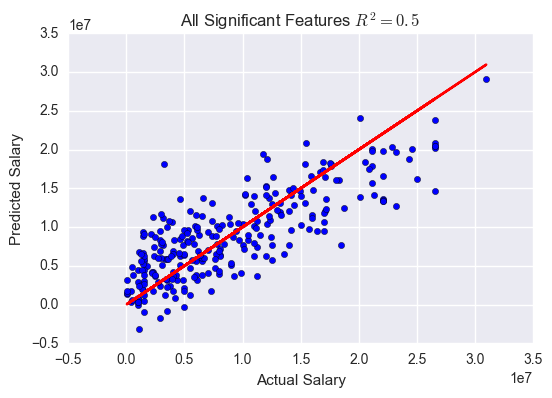

In [300]:
fig,ax = plt.subplots(1,1)
ax.scatter(Y,fit2.predict(X))
ax.plot(Y, Y, color='red')
ax.set_ylabel('Predicted Salary')
ax.set_xlabel('Actual Salary')
ax.set_title('All Significant Features $R^2=0.5$')

In [301]:
cross_val_R2_RMSE(X, Y, model2)

[0.57702808553799301, 0.049023762218052713, 0.43748190044665858, 0.46036784638615702, 0.46867279680741358]
mean R^2 0.398514878279
[5061845.963735826, 4385818.6854307335, 5611175.118574893, 4891864.144457485, 5240843.89099724]
mean rmse 5038309.560639235


## Model 3: all non-team variables 
### Cross validated $R^2\approx 0.51$

In [303]:
# Get non-team variables
feats_no_team=[feat for feat in df_dummy.columns if 'Tm' not in feat]
feats_no_team
df_no_team=df_dummy[feats_no_team]

In [304]:
Y=df_no_team['Salary']
X=df_no_team.drop('Salary', axis=1)
model3 = sm.OLS(Y, X)
fit3 = model3.fit()
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     12.62
Date:                Tue, 31 Jan 2017   Prob (F-statistic):           1.83e-36
Time:                        12:18:03   Log-Likelihood:                -4496.3
No. Observations:                 270   AIC:                             9063.
Df Residuals:                     235   BIC:                             9189.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept       -3.288e+08   3.08e+08     -1.068      0.287     -9.35e+08  2.78e+08
Pos[T.PF]       -7.141e+06   8.43e+06     -0.847      0.398     -2.38e+07  9.47e+06
Pos[T.PF-C]      1.411e+06    4.8e+06      0.294      0.769     -8.05e+06  1.09e+07
Pos[T.PG]        -3.57e+07    1.7e+07     -2.106      0.036     -6.91e+07  -2.3e+06
Pos[T.SF]       -1.067e+07   1.16e+07     -0.922      0.358     -3.35e+07  1.21e+07
Pos[T.SG]       -1.555e+07   1.49e+07     -1.040      0.299      -4.5e+07  1.39e+07
Shoots[T.Right]   3.03e+06   1.69e+07      0.180      0.858     -3.02e+07  3.63e+07
Experience       3.421e+05   2.68e+07      0.013      0.990     -5.24e+07  5.31e+07
Height           3.784e+08   2.61e+08      1.448      0.149     -1.37e+08  8.93e+08
Weight          -8.507e+07   8.87e+07     -0.959      0.339      -2.6e+08  8.97e+07
Age              5.108e+07   8.93e+07      0.572      0.568     -1.25e+08  2.27e+08
G                4.168e+06   2.33e+07      0.179      0.858     -4.18e+07  5.01e+07
GS              -5.257e+06   1.23e+07     -0.426      0.670     -2.95e+07   1.9e+07
MP               1.022e+08   4.68e+07      2.184      0.030         1e+07  1.94e+08
FG               1.026e+09   6.64e+08      1.546      0.123     -2.81e+08  2.33e+09
FGP              6.263e+07   1.85e+08      0.338      0.736     -3.02e+08  4.28e+08
P3               -4.42e+07   1.52e+08     -0.291      0.771     -3.44e+08  2.55e+08
PA3              6.667e+07   6.74e+07      0.989      0.324     -6.62e+07  1.99e+08
PP3              9.818e+06   1.55e+07      0.634      0.526     -2.07e+07  4.03e+07
P2              -1.107e+08   3.72e+08     -0.297      0.766     -8.44e+08  6.23e+08
PA2             -1.159e+08   1.14e+08     -1.015      0.311     -3.41e+08  1.09e+08
PP2              -8.45e+07    1.2e+08     -0.707      0.481      -3.2e+08  1.51e+08
eFGP             2.076e+07    1.6e+08      0.130      0.897     -2.94e+08  3.36e+08
FT               1.615e+08   1.56e+08      1.037      0.301     -1.45e+08  4.68e+08
FTA              4.485e+07   5.17e+07      0.867      0.387      -5.7e+07  1.47e+08
FTP              -3.61e+07   4.58e+07     -0.788      0.431     -1.26e+08  5.41e+07
ORB               8.68e+07   1.23e+08      0.707      0.480     -1.55e+08  3.29e+08
DRB              2.595e+08   3.52e+08      0.736      0.462     -4.35e+08  9.54e+08
TRB             -3.147e+08   4.68e+08     -0.673      0.501     -1.24e+09  6.06e+08
AST              9.634e+07   2.02e+07      4.781      0.000      5.66e+07  1.36e+08
STL             -3.847e+07   1.62e+07     -2.369      0.019     -7.05e+07 -6.48e+06
BLK              5.697e+06   1.16e+07      0.491      0.624     -1.72e+07  2.86e+07
TOV             -8.194e+07   2.85e+07     -2.873      0.004     -1.38e+08 -2.58e+07
PF              -4.344e+07   2.69e+07     -1.614      0.108

In [308]:
cross_val_R2_RMSE(X, Y, model3)

[0.5722637594005322, 0.45128032792434158, 0.75540394508321906, 0.5107744617241522, 0.28537065472509715]
mean R^2 0.515018629771
[4826037.51902953, 5234544.883234077, 3511027.770546089, 4564594.498887479, 5809317.995871227]
mean rmse 4789104.533513681


## Model 4: $L^1$ (Lasso) regularization
### Cross Validated $R^2\approx 0.45$
#### First I made a plot of RMSE against the regularization hyper-parameter $\alpha$. Then I did a binary search to find the value of $\alpha$ that minimized the RMSE. I settled on $14000$. 

## Graph of $\alpha$ vs. RMSE for $L^1$ regularization

In [318]:
kf = KFold(n=len(X), n_folds=5, shuffle=True)

all_scores=[]
alphas=[1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,1e2,1e3,1e4,1e5,1e6,1e7,1e8]

for a in alphas:
    mse_score=[]
    for train, test in kf:
        X_train=X_copy.iloc[train]
        Y_train=Y_norm.iloc[train]
        X_test=X_copy.iloc[test]
        Y_test=Y_norm.iloc[test]
        
        est=Lasso(alpha=a)
        est.fit(X_train,Y_train)
        mse=np.mean((Y_test-est.predict(X_test))**2)
        mse_score.append(mse)
    all_scores.append(sum(mse_score)/5)

/Users/michaelcantrell/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


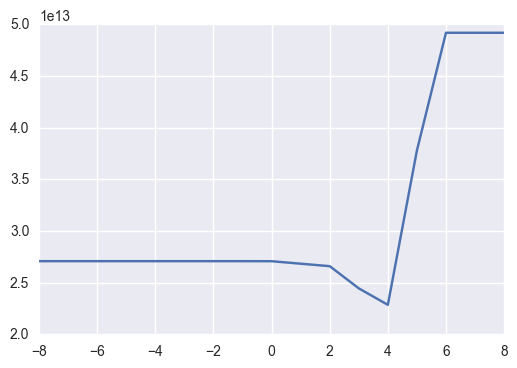

In [320]:
plt.plot(alphas,all_scores)

In [97]:
est_14000=Lasso(alpha=14000)
est_14000.fit(X_norm,Y_norm)

cross_val_R2_RMSE(X_norm, Y_norm, est_14000)

[0.41109551097445152, 0.28584733282149188, 0.47437663170725863, 0.60986897110458094, 0.47356954670307527]
mean R^2 0.450951598662
[5081715.018120547, 5884008.5915700905, 4542380.9207048165, 4255790.189688566, 5923289.651186126]
mean rmse 5137436.874254029


In [323]:
est_14000=Lasso(alpha=14000)
est_14000.fit(X_norm,Y_norm)
coefs_14000=list(zip(est_14000.coef_, X_copy))

#### Now let's take a look at the features that survived the regularization, as well as their coefficient size.

In [324]:
coefs_14000=list(filter(lambda x:abs(x[0])>1,coefs_14000))
coefs_14000.sort(key=lambda x:x[0])
coefs_14000

[(-12258924.610908022, 'Pos[T.PG]'),
 (-8716991.4027294796, 'Tm[T.PHI]'),
 (-3555469.6999487467, 'Tm[T.SAC]'),
 (-3024502.4924398069, 'Tm[T.LAL]'),
 (-1961596.6276758087, 'Tm[T.MIN]'),
 (-1922448.5429581341, 'Tm[T.UTA]'),
 (-1535185.1072704042, 'Tm[T.TOT]'),
 (-792044.80044924503, 'Tm[T.BOS]'),
 (717102.32613249321, 'Tm[T.CHI]'),
 (1346254.1377877456, 'Tm[T.SAS]'),
 (1628250.4262567232, 'Tm[T.LAC]'),
 (2859012.3189284257, 'Tm[T.TOR]'),
 (2872529.1370363687, 'BLK'),
 (5462040.7249175347, 'Tm[T.MIA]'),
 (8767224.1449424233, 'FTA'),
 (9802988.1571415532, 'GS'),
 (11280595.725454133, 'Tm[T.CLE]'),
 (11341883.667792821, 'P2'),
 (18567810.073989619, 'FT'),
 (22068882.808842815, 'AST'),
 (35121714.701695912, 'DRB'),
 (70493573.756092355, 'FG')]

## Model 5: only use features which a player can work on himself to improve
### Cross Validated $R^2\approx 0.43$

In [82]:
impr=['Salary','PP3','PP2','FTP','ORB','DRB','AST','STL','BLK','TOV','PF','Weight','Height']
df_impr=df_dummy[impr]
df_impr.head()

,Salary,PP3,PP2,FTP,ORB,DRB,AST,STL,BLK,TOV,PF,Weight,Height
0,3386598.0,0.063600,0.056476,0.064732,0.013563,0.023816,0.046296,0.033692,0.008681,0.049300,0.038207,0.051605,0.055832
1,2348783.0,0.055466,0.066297,0.065524,0.085901,0.082561,0.034219,0.074122,0.104171,0.064469,0.079353,0.065114,0.063480
2,17638063.0,0.081904,0.064824,0.069248,0.058774,0.087324,0.052334,0.121290,0.086809,0.056885,0.052902,0.062142,0.060421
3,7250000.0,0.074878,0.054020,0.063781,0.004521,0.022228,0.064411,0.040430,0.008681,0.053092,0.041146,0.049444,0.055067
4,4000000.0,0.020522,0.051933,0.059424,0.013563,0.028579,0.008051,0.006738,0.008681,0.003792,0.020573,0.063493,0.061185


In [335]:
Y=df_impr['Salary']
X=df_impr.drop('Salary', axis=1)
model5 = sm.OLS(Y, X)
fit5 = model5.fit()
fit5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     89.08
Date:                Tue, 31 Jan 2017   Prob (F-statistic):           2.03e-84
Time:                        12:19:16   Log-Likelihood:                -4547.3
No. Observations:                 270   AIC:                             9119.
Df Residuals:                     258   BIC:                             9162.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
PP3         2.512e+07   1.47e+07      1.707      0.089     -3.85e+06  5.41e+07
PP2         5.455e+07   5.01e+07      1.089      0.277     -4.41e+07  1.53e+08
FTP         5.507e+07   3.93e+07      1.402      0.162     -2.23e+07  1.32e+08
ORB         3.547e+06   1.72e+07      0.206      0.837     -3.04e+07  3.75e+07
DRB         1.198e+08   2.46e+07      4.875      0.000      7.14e+07  1.68e+08
AST         4.117e+07    1.8e+07      2.288      0.023      5.74e+06  7.66e+07
STL         6.056e+05   1.65e+07      0.037      0.971      -3.2e+07  3.32e+07
BLK         1.161e+07    1.2e+07      0.971      0.333     -1.19e+07  3.51e+07
TOV         3.216e+07   2.53e+07      1.269      0.206     -1.77e+07  8.21e+07
PF         -5.282e+07   2.68e+07     -1.969      0.050     -1.06e+08  5998.901
Weight      9.698e+07   8.32e+07      1.166      0.245     -6.68e+07  2.61e+08
Height     -2.067e+08   1.13e+08     -1.829      0.069     -4.29e+08  1.58e+07
==============================================================================
Omnibus:                       11.024   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.258
Skew:                           0.454   Prob(JB):                      0.00359
Kurtosis:                       3.418   Cond. No.                         85.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [336]:
cross_val_R2_RMSE(X, Y, model5)

[0.30215553892049873, 0.40645414797782853, 0.59207007851442128, 0.42301712150186244, 0.4288301330700014]
mean R^2 0.430505403997
[5882761.458240195, 6085560.125926596, 4063838.347657518, 5154975.480692278, 4874751.253321952]
mean rmse 5212377.333167708


### Surprisingly, Defensive Rebounds are more correlated with salary than 3 Point Percentange.

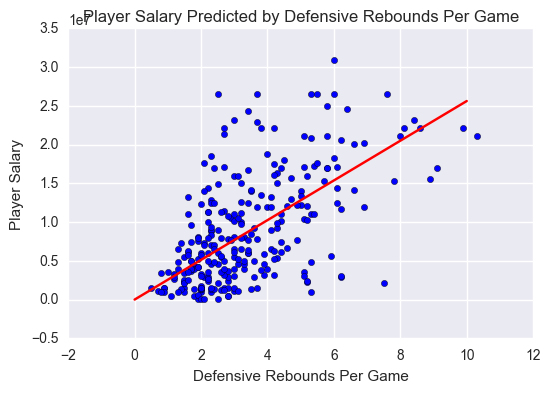

In [338]:
fig,ax = plt.subplots(1,1)
x_plot = np.linspace(0, 10, 100)
ax.scatter(x,y)
ax.plot(x_plot, model.predict(x_plot[:, np.newaxis]), color='red')
ax.set_ylabel('Player Salary')
ax.set_xlabel('Defensive Rebounds Per Game')
ax.set_title('Player Salary Predicted by Defensive Rebounds Per Game')

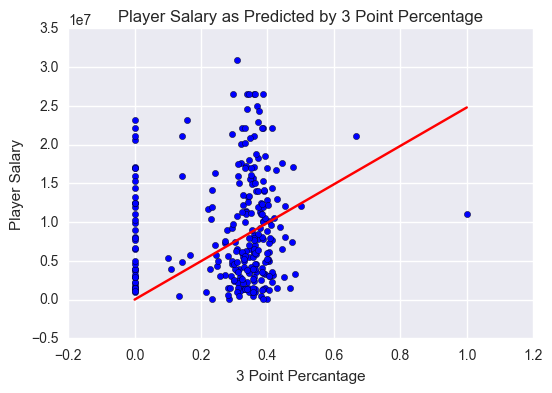

In [340]:
fig,ax = plt.subplots(1,1)
x_plot = np.linspace(0, 1, 100)
ax.scatter(x,y)
ax.plot(x_plot, model.predict(x_plot[:, np.newaxis]), color='red')
ax.set_ylabel('Player Salary')
ax.set_xlabel('3 Point Percantage')
ax.set_title('Player Salary as Predicted by 3 Point Percentage')